In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.0.1+cu118
transformers: 4.31.0



In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration


In [ ]:
df = pd.read_excel("/content/Hate Comments.xlsx")
df.head(10)

,Com,Class
0,বড়রাচোদা আদিবাসী গুলান। অগোর পিছে দিয়া বাঁশ ...,1
1,শুয়োরের বাচ্চা গুলা খায় ও শুয়োর স্বভাব ও শু...,1
2,আমি বুঝি না এই বানরের বাচ্চাগুলা দেশের প্রশাসন...,1
3,থাকতে দিসি দেশে থাকবে গোলামের মত। ওমা এরা দেখি...,1
4,শালার মাদারচোদের দেশে থাকি। দেশের মানুষের দাম ...,1
5,আদিবাসী মানেই ঝামেলা। দেশের স্বাধীনতা কি এই বা...,1
6,শালাা বানর চোদা খানকি মাগীর দল।,1
7,আদিবাসী খানকি মাগি ডি বানর বেইসশার লগে সহবাস ক...,1
8,বানর চোদে বানররে আদিবাসী চোদে আদিবাসী রে। কিন্...,1
9,চিড়িয়াখানা তে সেদিন দেখি বানর অনেক কম। এই আদিব...,1


In [ ]:
df=df.dropna()

In [ ]:
df.shape

(3067, 2)

In [ ]:
df[:]

,Com,Class
0,বড়রাচোদা আদিবাসী গুলান। অগোর পিছে দিয়া বাঁশ ...,1
1,শুয়োরের বাচ্চা গুলা খায় ও শুয়োর স্বভাব ও শু...,1
2,আমি বুঝি না এই বানরের বাচ্চাগুলা দেশের প্রশাসন...,1
3,থাকতে দিসি দেশে থাকবে গোলামের মত। ওমা এরা দেখি...,1
4,শালার মাদারচোদের দেশে থাকি। দেশের মানুষের দাম ...,1
...,...,...
3063,"ইশ আপু,আপনার বাল আজকে আপনার ইজ্জত রক্ষা করছে!",3
3064,ওর মুখে থু থু মারেন,3
3065,সিরাজুদ্দৌলার সাথে দেখা কর গিয়া মাগি,3
3066,হিংসা হয় আমার ছবিটা দেখে,3


In [ ]:
df['Class'].value_counts()

3    1011
2     792
0     751
1     513
Name: Class, dtype: int64

In [ ]:
df=df[df['Class'] != 3]

In [ ]:
df['Class'].value_counts()

2    792
0    751
1    513
Name: Class, dtype: int64

We have about 16k examples. Let's check for missing values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2056 entries, 0 to 2056
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Com     2056 non-null   object
 1   Class   2056 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.2+ KB


In [ ]:
#class_names = ['Trans', 'Indigenous','Migrated','Universal Toxic']
class_names = ['Trans', 'Indigenous','Migrated']

Great, no missing values in the score and review texts! Do we have class imbalance?

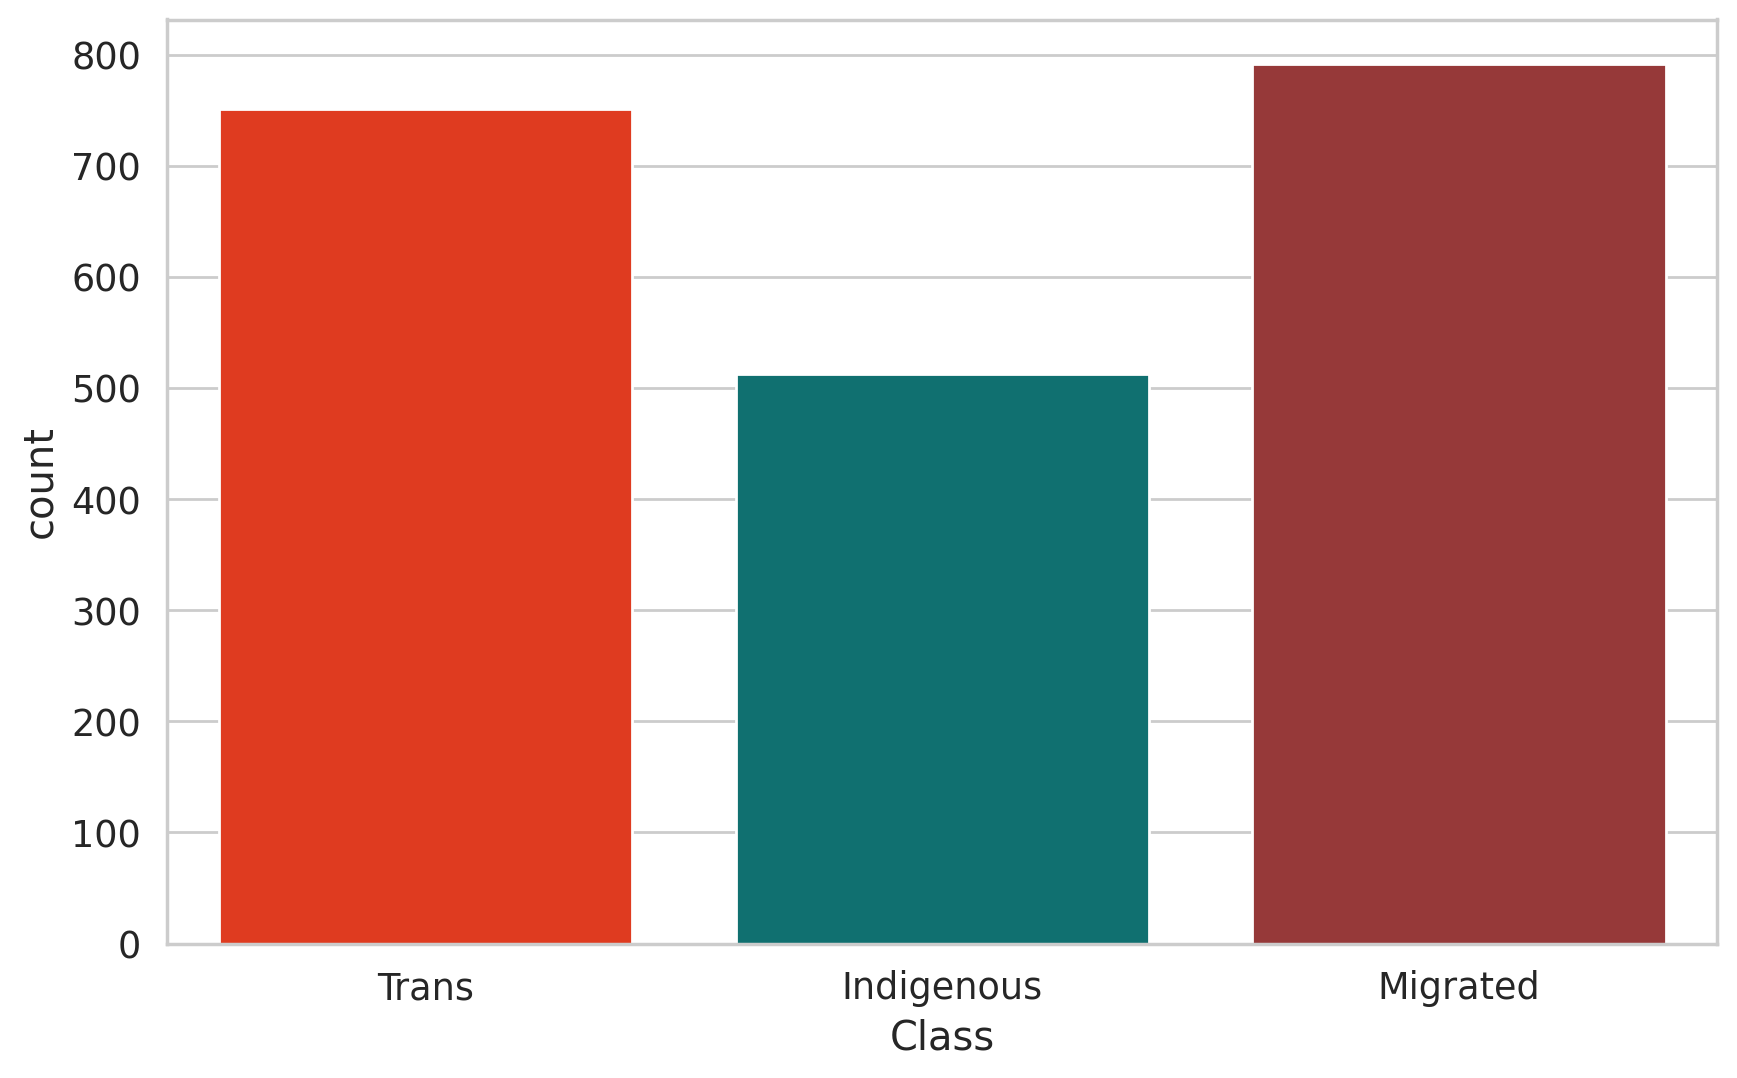

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))

Toxic_count = df['Class'].value_counts()
#sns.countplot(x='Score', data=df, order=Toxic_count.index)
#sns.countplot(x='Score', data=df, order=Toxic_count.index, color='blue')
sns.countplot(x='Class', data=df, palette=['#FF2400', 'teal','#A52A2A','Seagreen'])
# Rename the x-axis tick labels
new_labels = class_names# Replace with your desired labels
plt.gca().set_xticklabels(new_labels)

plt.show()


In [ ]:
from transformers import AutoTokenizer, AutoModel

bnbert_tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
text = "আমি বাংলায় গান গাই।"
bnbert_tokenizer.tokenize(text)
# ['আমি', 'বাংলা', '##য', 'গান', 'গাই', '।']

from transformers import BertForMaskedLM, BertTokenizer, pipeline

model = BertForMaskedLM.from_pretrained("sagorsarker/bangla-bert-base")
tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer)
for pred in nlp(f"আমি বাংলায় {nlp.tokenizer.mask_token} গাই।"):
  print(pred)

# {'sequence': '[CLS] আমি বাংলায গান গাই । [SEP]', 'score': 0.13404667377471924, 'token': 2552, 'token_str': 'গান'}



Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'score': 0.1340467482805252, 'token': 2552, 'token_str': 'গান', 'sequence': 'আমি বাংলায গান গাই ।'}
{'score': 0.06138582527637482, 'token': 2058, 'token_str': '##ও', 'sequence': 'আমি বাংলাযও গাই ।'}
{'score': 0.047230105847120285, 'token': 4122, 'token_str': 'সাহিত্য', 'sequence': 'আমি বাংলায সাহিত্য গাই ।'}
{'score': 0.04314073547720909, 'token': 4459, 'token_str': 'কবিতা', 'sequence': 'আমি বাংলায কবিতা গাই ।'}
{'score': 0.013253453187644482, 'token': 3264, 'token_str': 'শব্দ', 'sequence': 'আমি বাংলায শব্দ গাই ।'}


In [ ]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
PRE_TRAINED_MODEL_NAME = 'sagorsarker/bangla-bert-base' #sagorsarker/bangla-bert-base #bert-base-cased #csebuetnlp/banglabert #neuropark/sahajBERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) #AutoTokenizer.from_pretrained("csebuetnlp/banglabert") PreTrainedTokenizerFast.from_pretrained("neuropark/sahajBERT")

In [ ]:
sample_txt = 'আমি মুকাফফি '

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: আমি মুকাফফি 
   Tokens: ['আমি', 'মক', '##াফ', '##ফি']
Token IDs: [2169, 31465, 31635, 10321]


Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: আমি মুকাফফি 
   Tokens: ['আমি', 'মক', '##াফ', '##ফি']
Token IDs: [2169, 31465, 31635, 10321]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2169, 31465, 31635, 10321,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'আমি',
 'মক',
 '##াফ',
 '##ফি',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = []

for txt in df.Com:
  #txt = normalize(txt) # this normalization step is required before tokenizing the text
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


and plot the distribution:

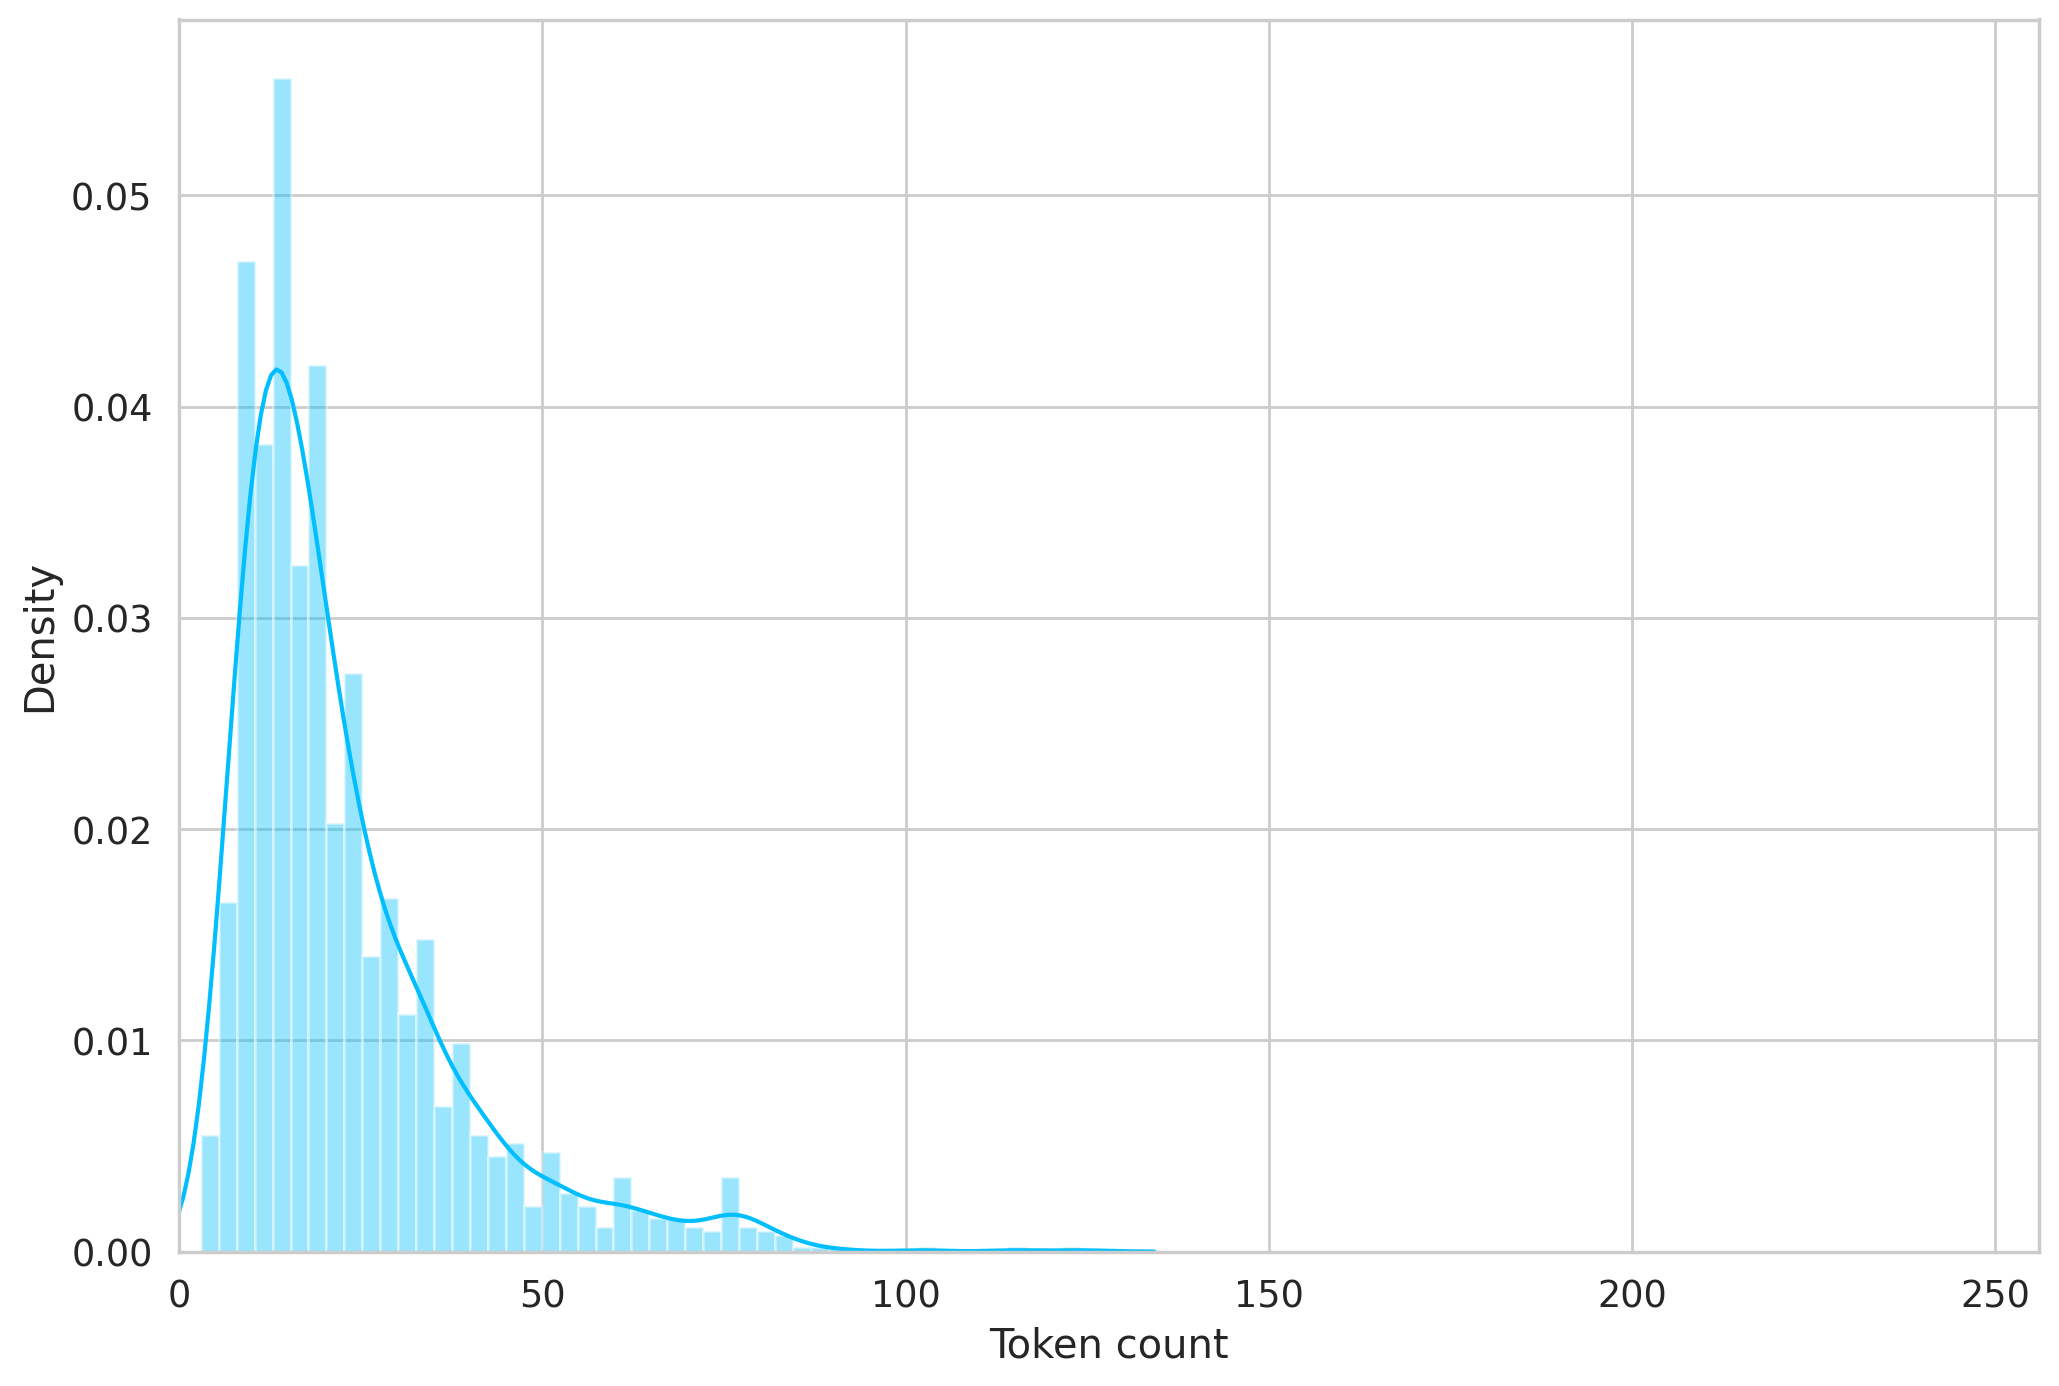

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    review = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'toxic_comments': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.75,shuffle=True)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((1439, 2), (154, 2), (463, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.Com.to_numpy(),
    targets=df.Class.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [ ]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['toxic_comments', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 160])
torch.Size([8, 160])
torch.Size([8])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

In [ ]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [ ]:
torch.cuda.empty_cache()

And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
PRE_TRAINED_MODEL_NAME

'sagorsarker/bangla-bert-base'

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class ToxicClassifier(nn.Module):

  def __init__(self, n_classes):
    super(ToxicClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = ToxicClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 160])
torch.Size([8, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4564, 0.3938, 0.1498],
        [0.4481, 0.3746, 0.1773],
        [0.5346, 0.2883, 0.1770],
        [0.5239, 0.2265, 0.2496],
        [0.4791, 0.3301, 0.1907],
        [0.5064, 0.3277, 0.1659],
        [0.5261, 0.3343, 0.1395],
        [0.5420, 0.3544, 0.1036]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

[link text](https://)Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.2061572547978964 accuracy 0.9631688672689367


In [ ]:
model=ToxicClassifier(len(class_names))

In [ ]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  toxic_comments = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["toxic_comments"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      toxic_comments.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return toxic_comments, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

       Trans     0.8750    0.8750    0.8750       152
  Indigenous     0.8942    0.8017    0.8455       116
    Migrated     0.8356    0.9104    0.8714       134

    accuracy                         0.8657       402
   macro avg     0.8683    0.8624    0.8640       402
weighted avg     0.8674    0.8657    0.8653       402



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

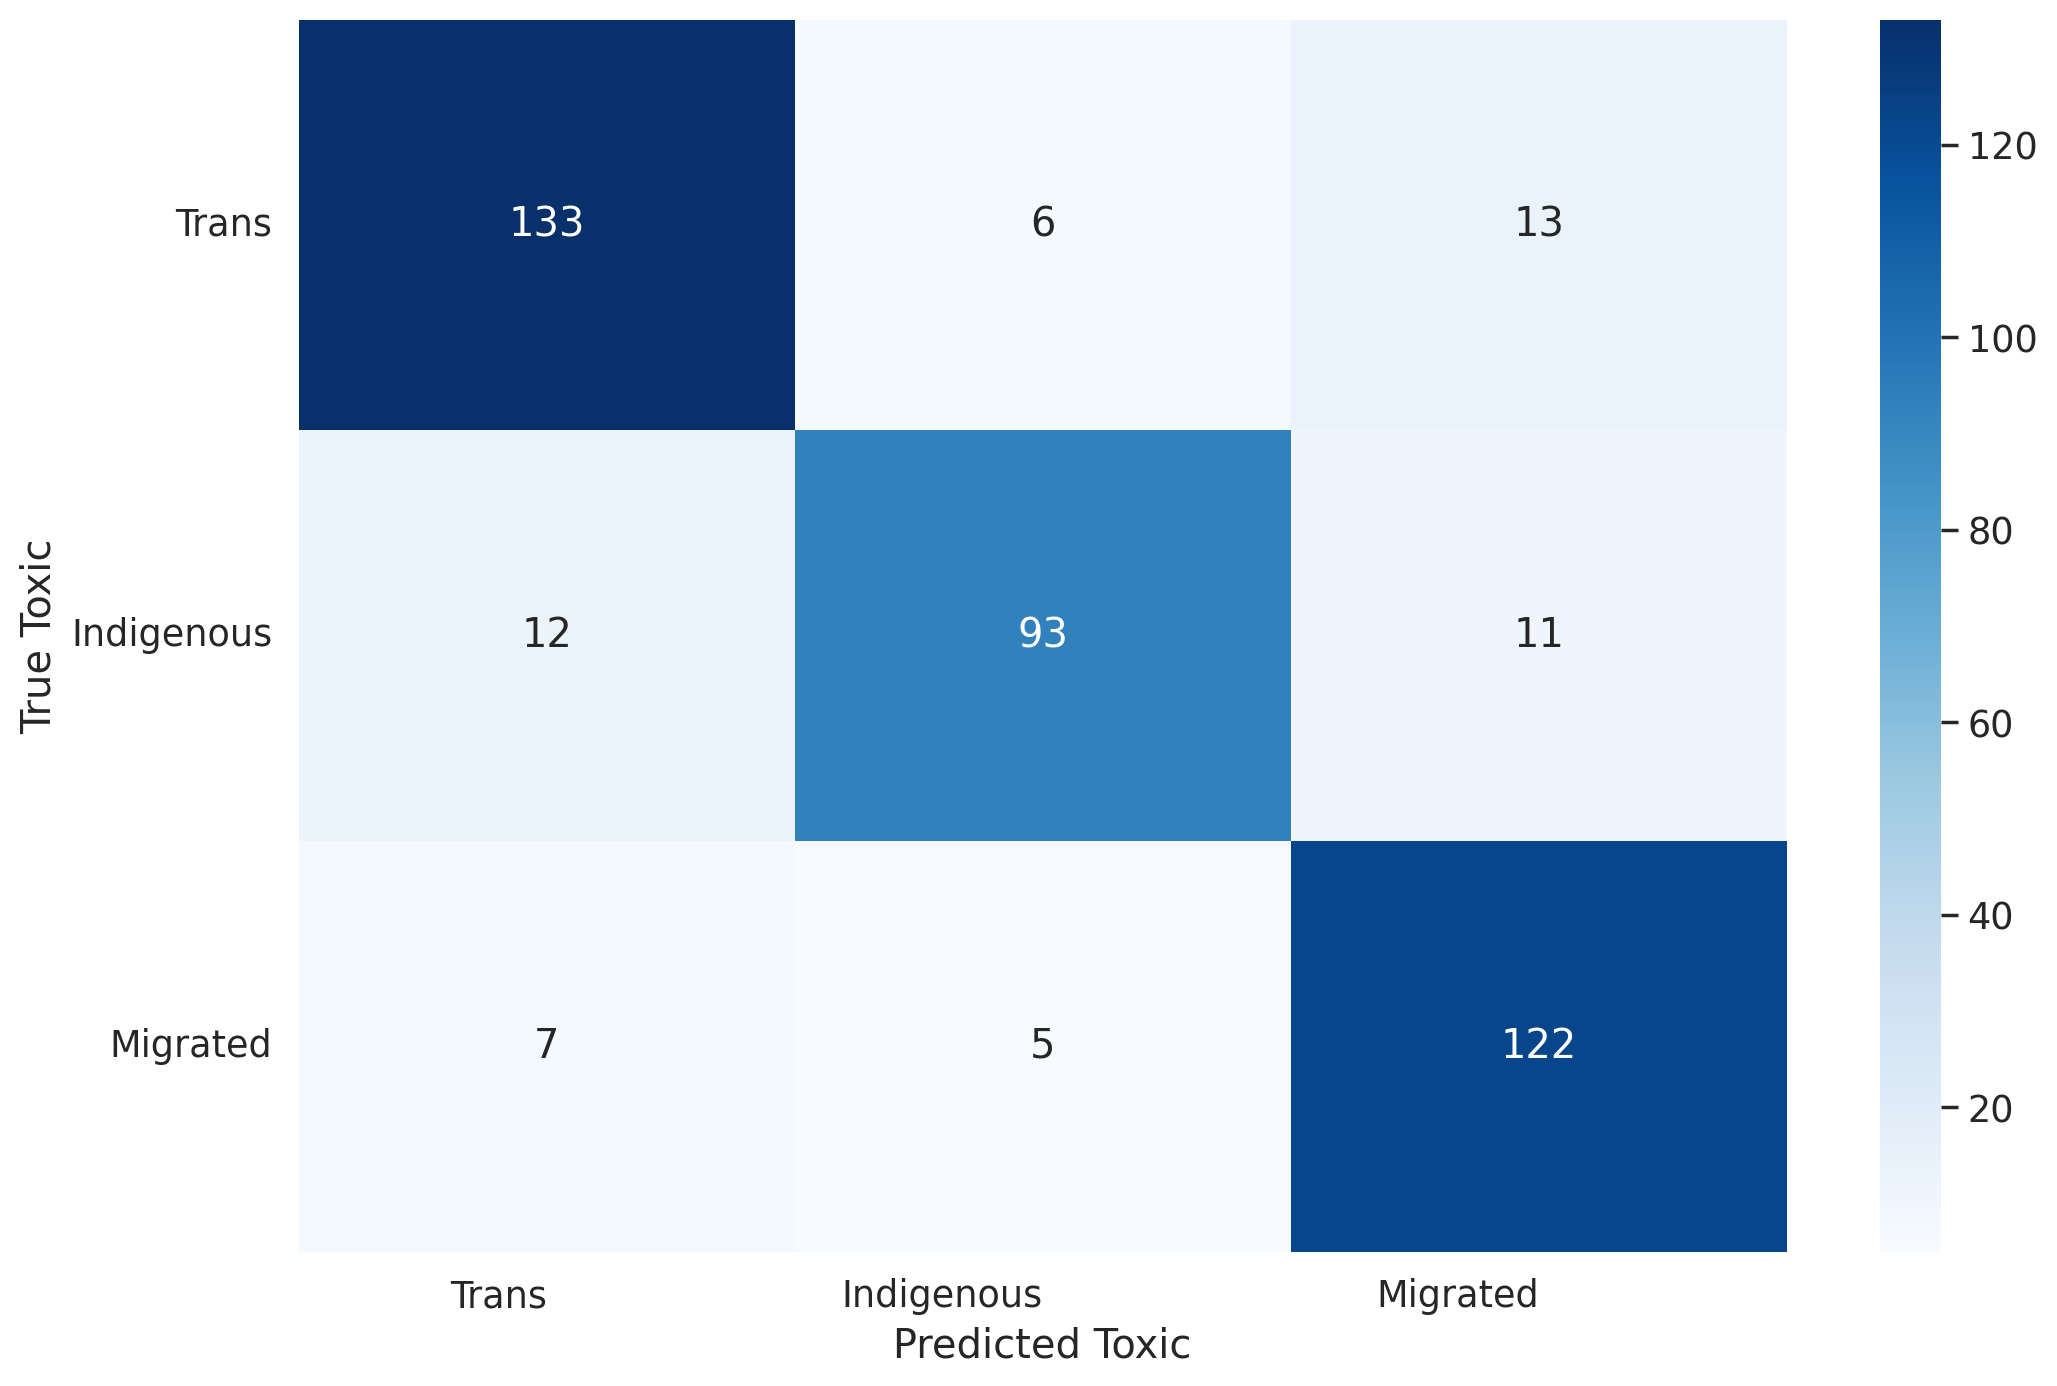

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True Toxic')
  plt.xlabel('Predicted Toxic');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 40

review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True Label: {class_names[true_label]}')

এই দেশে গরুর কালা ভুনা খাইতে পারে,খুব আরামে আছে,আর কত থাকবা,এবার নিজ
দেশে যাওয়ার চেষ্টা কর বাবুরা

True Label: Migrated


Now we can look at the confidence of each sentiment of our model:

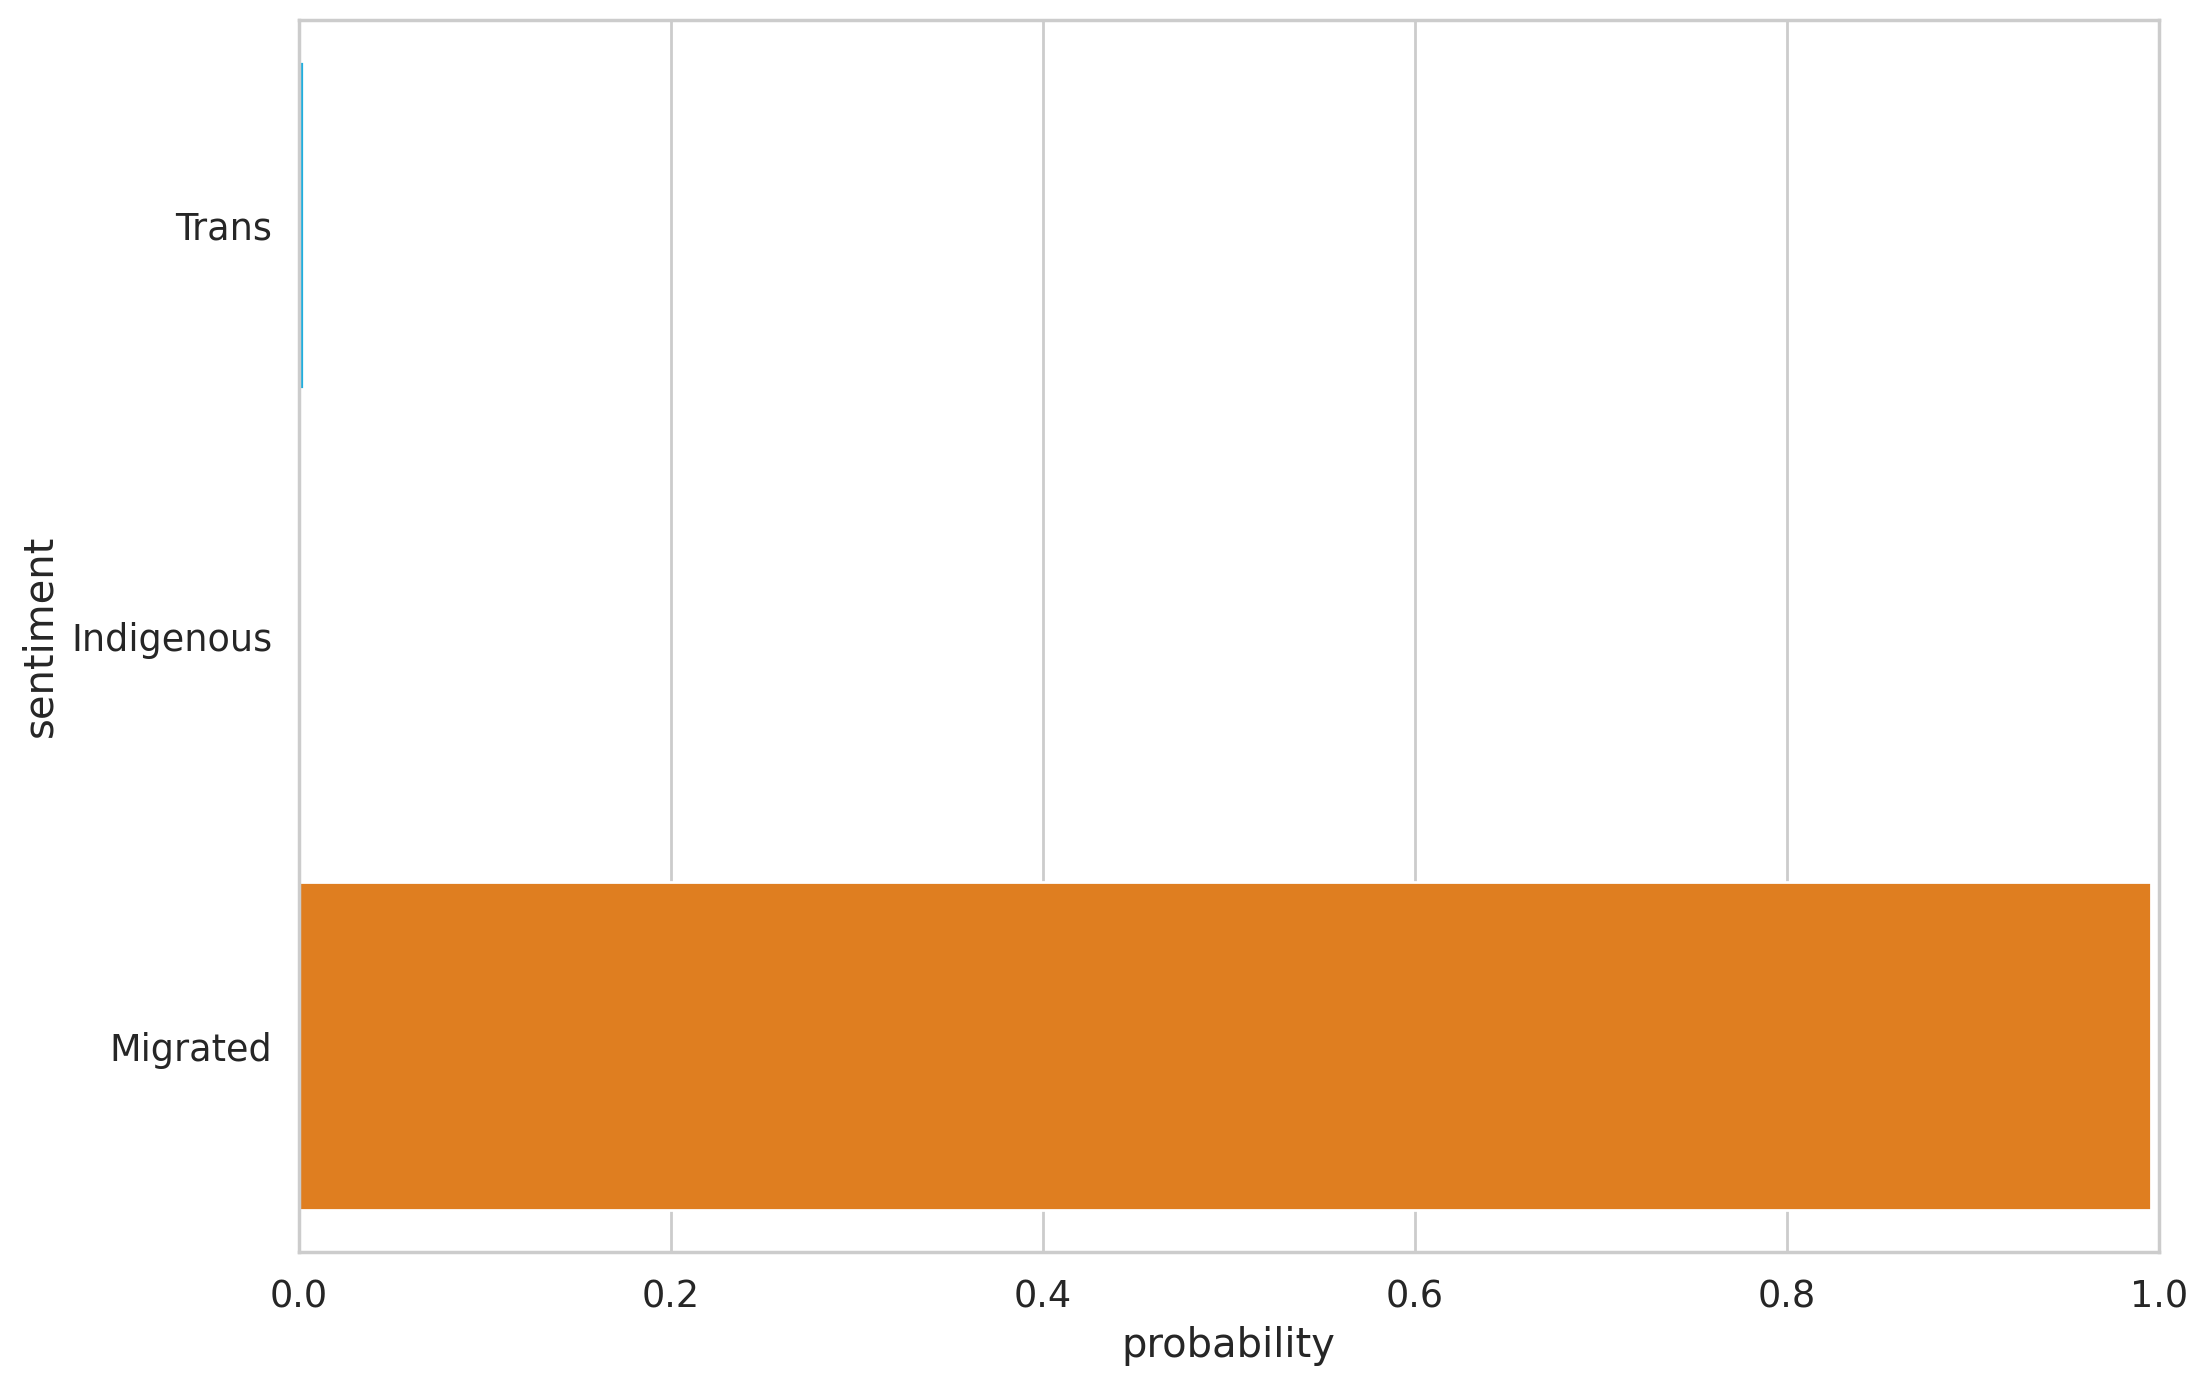

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
Toxic_com = "নুনু আছে?"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  Toxic_com,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Toxic text: {Toxic_com}')
print(f'Prediction  : {class_names[prediction]}')

Toxic text: নুনু আছে?
Prediction  : Trans


In [ ]:
review_text = "এগুলো খাওয়া হারাম?"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: এগুলো খাওয়া হারাম?
Sentiment  : Indigenous
